## 1. Importando as bibliotecas e leitura dos dados

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)

# Caminho dos dados
caminho_dados = '../Dados_Treino_Teste'

# Carregando os dados
X_treino = pd.read_csv(f'{caminho_dados}/X_treino.csv')
X_teste = pd.read_csv(f'{caminho_dados}/X_teste.csv')
y_treino = pd.read_csv(f'{caminho_dados}/y_treino.csv').squeeze()
y_teste = pd.read_csv(f'{caminho_dados}/y_teste.csv').squeeze()


## 2. Definir a grade de hiperparâmetros para o RandomizedSearchCV

In [3]:
modelo_rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],  # Evite None se quiser mais controle
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

random_search = RandomizedSearchCV(
    estimator=modelo_rf,
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    verbose=2,
    n_jobs=-1  # usando todos os núcleos disponíveis
)

inicio = time.perf_counter()
random_search.fit(X_treino, y_treino)
fim = time.perf_counter()

duracao = fim - inicio
minutos, segundos = divmod(duracao, 60)

print(f"Tempo de treinamento: {int(minutos)}m {segundos:.2f}s")

melhor_modelo_rf = random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tempo de treinamento: 12m 26.90s


In [4]:
# Acessando o melhor modelo encontrado
melhor_modelo_rf = random_search.best_estimator_

# Exibindo os melhores hiperparâmetros encontrados
print("\n Melhores hiperparâmetros encontrados:")
for parametro, valor in random_search.best_params_.items():
    print(f"  - {parametro}: {valor}")

print(f"\n Score de validação cruzada do melhor modelo: {random_search.best_score_:.4f}")



 Melhores hiperparâmetros encontrados:
  - n_estimators: 100
  - min_samples_split: 2
  - min_samples_leaf: 1
  - max_depth: 30

 Score de validação cruzada do melhor modelo: 0.9994


## 3. Avaliação no conjunto de Teste

In [5]:
# Previsões e avaliação com o melhor modelo
y_pred_teste = melhor_modelo_rf.predict(X_teste)
y_proba = melhor_modelo_rf.predict_proba(X_teste)[:, 1]
roc_auc = roc_auc_score(y_teste, y_proba)

# Contagem de cancelamentos previstos
quantidade_cancelamentos = int(np.sum(y_pred_teste == 1))
quantidade_nao_cancelamentos = int(np.sum(y_pred_teste == 0))

# Valores reais no conjunto de teste
cancelamentos_reais = int(np.sum(y_teste == 1))
nao_cancelamentos_reais = int(np.sum(y_teste == 0))

# Dicionário de resultados
resultados_rf = {
    'Acurácia': round(accuracy_score(y_teste, y_pred_teste), 4),
    'Precisão': round(precision_score(y_teste, y_pred_teste), 4),
    'Recall': round(recall_score(y_teste, y_pred_teste), 4),
    'F1-score': round(f1_score(y_teste, y_pred_teste), 4),
    'AUC': round(roc_auc, 4),
    'Cancelamentos previstos': int(quantidade_cancelamentos),
    'Cancelamentos reais': int(cancelamentos_reais),
    'Não cancelamentos previstos': int(quantidade_nao_cancelamentos),
    'Não cancelamentos reais': int(nao_cancelamentos_reais),
}

# Exibir a tabela de resultados
df_resultados_rf = pd.DataFrame.from_dict(resultados_rf, orient='index', columns=['Random Forest'])
print(df_resultados_rf)


                             Random Forest
Acurácia                            0.9996
Precisão                            0.9999
Recall                              0.9993
F1-score                            0.9996
AUC                                 1.0000
Cancelamentos previstos         49969.0000
Cancelamentos reais             50000.0000
Não cancelamentos previstos     38198.0000
Não cancelamentos reais         38167.0000


## 4. Matriz de Confusão

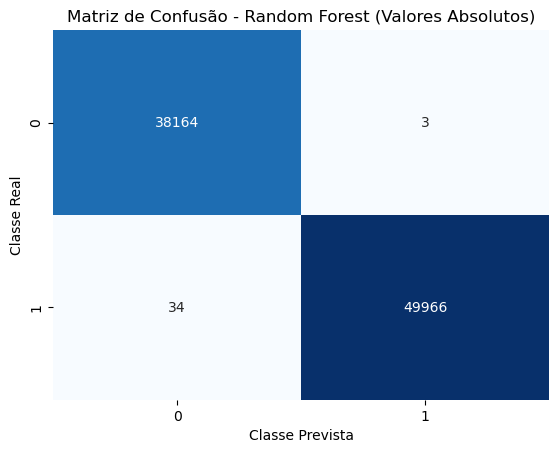

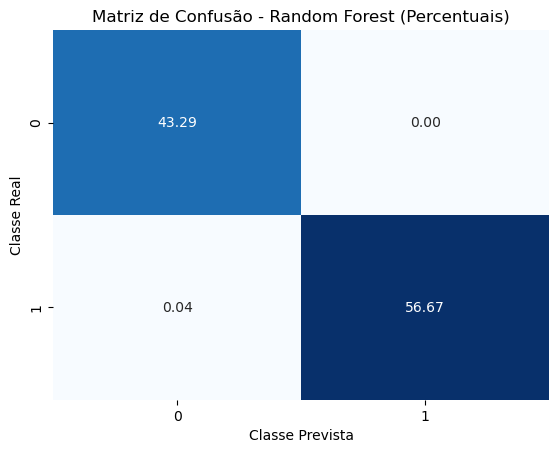

Matriz de Confusão - Interpretação (Random Forest):
→ Verdadeiros Negativos (TN): 38164
→ Falsos Positivos (FP): 3
→ Falsos Negativos (FN): 34
→ Verdadeiros Positivos (TP): 49966

Interpretação:
- O modelo acertou 49966 casos de cancelamento e 38164 casos de não cancelamento.
- Ele errou em 3 casos ao prever cancelamento onde não houve (falsos positivos).
- Cometeu 34 erros ao deixar de prever cancelamentos que ocorreram (falsos negativos).
- Falsos negativos são particularmente importantes, pois indicam clientes que cancelaram sem serem previstos pelo modelo.


In [6]:
# Matriz de confusão para o modelo Random Forest
cm_rf = confusion_matrix(y_teste, y_pred_teste)
cm_rf_normalizado = cm_rf / cm_rf.sum() * 100

# Plot - valores absolutos
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusão - Random Forest (Valores Absolutos)")
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Real")
plt.show()

# Plot - percentuais
sns.heatmap(cm_rf_normalizado, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.title("Matriz de Confusão - Random Forest (Percentuais)")
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Real")
plt.show()

# Explicação textual da matriz de confusão
tn, fp, fn, tp = cm_rf.ravel()

print("Matriz de Confusão - Interpretação (Random Forest):")
print(f"→ Verdadeiros Negativos (TN): {tn}")
print(f"→ Falsos Positivos (FP): {fp}")
print(f"→ Falsos Negativos (FN): {fn}")
print(f"→ Verdadeiros Positivos (TP): {tp}")

print("\nInterpretação:")
print(f"- O modelo acertou {tp} casos de cancelamento e {tn} casos de não cancelamento.")
print(f"- Ele errou em {fp} casos ao prever cancelamento onde não houve (falsos positivos).")
print(f"- Cometeu {fn} erros ao deixar de prever cancelamentos que ocorreram (falsos negativos).")
print("- Falsos negativos são particularmente importantes, pois indicam clientes que cancelaram sem serem previstos pelo modelo.")


## 5. Curva ROC

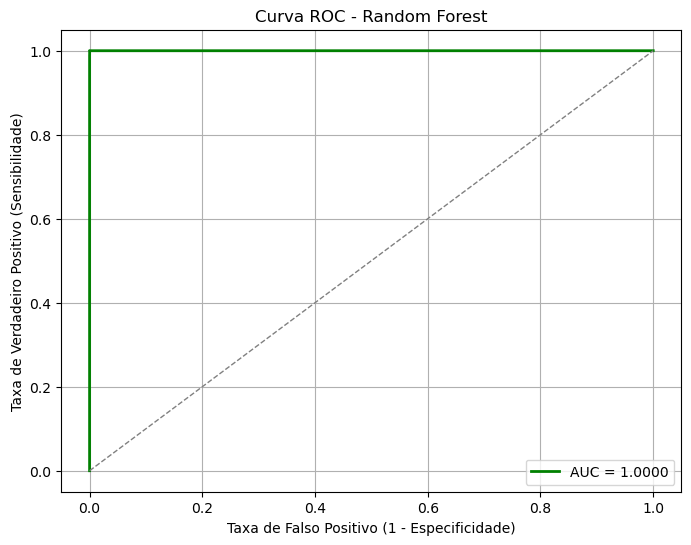

Interpretação da Curva ROC - Random Forest:
- A curva ROC mostra a relação entre a Sensibilidade (TPR) e a Especificidade (1 - FPR) para vários thresholds de decisão.
- O valor AUC (Área Sob a Curva) é 1.0000, indicando a capacidade do modelo de distinguir entre as classes.
- Excelente desempenho: modelo altamente discriminativo.
- Quanto mais próximo de 1, melhor o modelo. Um valor próximo a 0.5 indica um modelo aleatório.


In [7]:
# Probabilidades preditas para a classe positiva
y_proba_rf = melhor_modelo_rf.predict_proba(X_teste)[:, 1]

# Calcula taxas de falso positivo e verdadeiro positivo para diferentes thresholds
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_teste, y_proba_rf)

# Calcula área sob a curva ROC
auc_score_rf = roc_auc_score(y_teste, y_proba_rf)

# Plot da curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f"AUC = {auc_score_rf:.4f}")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel("Taxa de Falso Positivo (1 - Especificidade)")
plt.ylabel("Taxa de Verdadeiro Positivo (Sensibilidade)")
plt.title("Curva ROC - Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Interpretação detalhada da curva ROC
print("Interpretação da Curva ROC - Random Forest:")
print(f"- A curva ROC mostra a relação entre a Sensibilidade (TPR) e a Especificidade (1 - FPR) para vários thresholds de decisão.")
print(f"- O valor AUC (Área Sob a Curva) é {auc_score_rf:.4f}, indicando a capacidade do modelo de distinguir entre as classes.")
if auc_score_rf > 0.9:
    print("- Excelente desempenho: modelo altamente discriminativo.")
elif auc_score_rf > 0.8:
    print("- Bom desempenho: modelo com boa capacidade discriminativa.")
elif auc_score_rf > 0.7:
    print("- Desempenho razoável: modelo com capacidade moderada.")
else:
    print("- Desempenho fraco: modelo com pouca capacidade de discriminação.")
print("- Quanto mais próximo de 1, melhor o modelo. Um valor próximo a 0.5 indica um modelo aleatório.")


## 6. Avaliação de Múltiplas Métricas

In [9]:

# Reunindo todos os dados
X = pd.concat([X_treino, X_teste], axis=0)
y = pd.concat([y_treino, y_teste], axis=0)

# Avaliando as principais métricas
metricas = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
resultado = cross_validate(
    melhor_modelo_rf, X, y, cv=5, scoring=metricas, return_train_score=False
)

# Criando DataFrame com resultados
df_resultados_cv = pd.DataFrame(columns=['Métrica', 'Média', 'Desvio Padrão'])

for metrica in metricas:
    scores = resultado[f'test_{metrica}']
    media = np.mean(scores)
    desvio = np.std(scores)
    
    df_resultados_cv = pd.concat([
        df_resultados_cv,
        pd.DataFrame({'Métrica': [metrica.upper()],
                      'Média': [f'{media:.4f}'],
                      'Desvio Padrão': [f'{desvio:.4f}']})
    ], ignore_index=True)

# Exibindo resultados
display(df_resultados_cv)


,Métrica,Média,Desvio Padrão
0,ACCURACY,0.9996,0.0000
1,PRECISION,1.0000,0.0000
2,RECALL,0.9993,0.0001
3,F1,0.9996,0.0000
4,ROC_AUC,1.0000,0.0000


## 7. Comparar Desempenho no Treino e Teste (Checar Overfitting)

In [12]:
# Avaliação no conjunto de treino
y_pred_treino = melhor_modelo_rf.predict(X_treino)

metricas_treino = {
    'Acurácia': accuracy_score(y_treino, y_pred_treino),
    'Precisão': precision_score(y_treino, y_pred_treino),
    'Recall': recall_score(y_treino, y_pred_treino),
    'F1-score': f1_score(y_treino, y_pred_treino)
}

# Avaliação no conjunto de teste
# (Pode usar os valores de resultados_rf, como você já tinha feito)
metricas_teste = {
    'Acurácia': resultados_rf['Acurácia'],
    'Precisão': resultados_rf['Precisão'],
    'Recall': resultados_rf['Recall'],
    'F1-score': resultados_rf['F1-score']
}

# Comparação
df_comparacao = pd.DataFrame({
    'Métrica': list(metricas_treino.keys()),
    'Treino': [round(metricas_treino[m], 4) for m in metricas_treino],
    'Teste': [round(metricas_teste[m], 4) for m in metricas_teste]
}).set_index('Métrica')

# Exibir
display(df_comparacao)
print(df_comparacao)


,Treino,Teste
Métrica,,
Acurácia,1.0,0.9996
Precisão,1.0,0.9999
Recall,1.0,0.9993
F1-score,1.0,0.9996


          Treino   Teste
Métrica                 
Acurácia     1.0  0.9996
Precisão     1.0  0.9999
Recall       1.0  0.9993
F1-score     1.0  0.9996


## 8. Importância das variaveis (Random Forest)

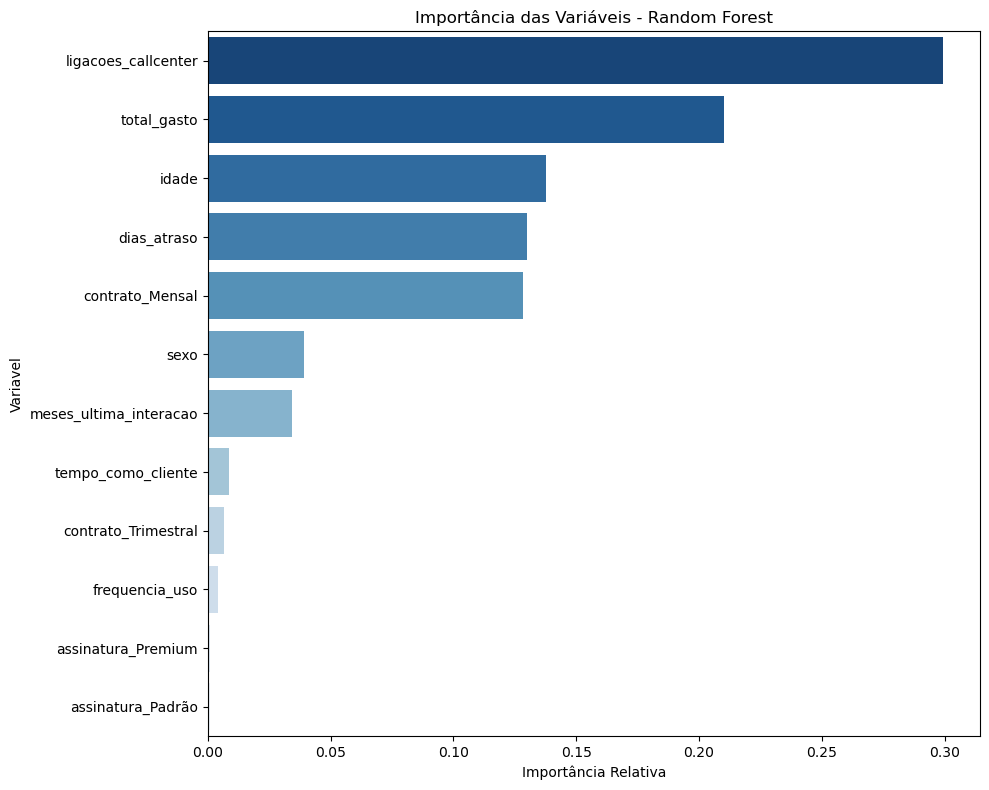

In [15]:
# Importância das variáveis segundo o Random Forest
importancias = melhor_modelo_rf.feature_importances_
variaveis = X_treino.columns

# Criação do DataFrame de importância
df_importancia_rf = pd.DataFrame({
    'Variavel': variaveis,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importancia',
    y='Variavel',
    data=df_importancia_rf.head(20),
    hue='Variavel',  # usar a própria variável como hue
    dodge=False,
    palette='Blues_r',
    legend=False  # evita legenda desnecessária
)
plt.title("Importância das Variáveis - Random Forest")
plt.xlabel("Importância Relativa")
plt.tight_layout()
plt.show()


## 9. Salvando o modelo Random Forest

In [17]:
import joblib

# Salvar o modelo treinado
joblib.dump(melhor_modelo_rf, 'modelo_Random_Forest.pkl')

# Carregar o modelo treinado
modelo_carregado = joblib.load('modelo_Random_Forest.pkl')